<a href="https://colab.research.google.com/github/keinam53/Deep_learning/blob/main/5_Konwolucyjne_Sieci_Neuronowe/2_Klasyfikacja_binarna.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### Klasyfikator binarny - Image Classification - Drone vs. Passenger Plane

1. [Import bibliotek](#a0)
2. [Załadowanie danych](#a1)
3. [Przygotowanie zbiorów: treningowego, walidacyjnego i testowego](#a2)
4. [Eksplorcja danych](#a3)
5. [Augmentacja danych](#a4)
6. [Budowa modelu](#a5)
7. [Transfer learning - model VGG16](#a6)
8. [Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw](#a7)
9. [Ocena modelu na zbiorze testowym](#a8)
10. [Wyświetlenie błędów predykcji](#a9)

### <a name='a0'></a> Import bibliotek

In [5]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import shutil
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix, classification_report

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import TensorBoard

np.set_printoptions(precision=6, suppress=True)

### <a name='a1'></a> Załadowanie danych

In [36]:
!wget https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
!unzip -q flying-vehicles.zip

--2021-09-28 18:33:47--  https://storage.googleapis.com/esmartdata-courses-files/ann-course/flying-vehicles.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 108.177.15.128, 173.194.76.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|108.177.15.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1540232238 (1.4G) [application/x-zip-compressed]
Saving to: ‘flying-vehicles.zip’

flying-vehicles.zip 100%[===================>]   1.43G   197MB/s    in 7.6s    

2021-09-28 18:33:54 (194 MB/s) - ‘flying-vehicles.zip’ saved [1540232238/1540232238]



### <a name='a2'></a> Przygotowanie zbiorów: treningowego, walidacyjnego i testowego

In [37]:
!rm -rf ./images

In [42]:
base_dir = './data/planes'
raw_no_of_files = {}
classes = ['drone', 'fighter-jet', 'helicopter', 'missile', 'passenger-plane', 'rocket']
for dir in classes:
    raw_no_of_files[dir] = len(os.listdir(os.path.join(base_dir, dir)))

raw_no_of_files.items()

dict_items([('drone', 1332), ('fighter-jet', 1867), ('helicopter', 1387), ('missile', 1334), ('passenger-plane', 1424), ('rocket', 1186)])

In [43]:
data_dir = './images'

if not os.path.exists(data_dir):
    os.mkdir(data_dir)

train_dir = os.path.join(data_dir, 'train')    # katalog zbioru treningowego
valid_dir = os.path.join(data_dir, 'valid')    # katalog zbioru walidacyjnego
test_dir = os.path.join(data_dir, 'test')      # katalog zbioru testowego

train_drone_dir = os.path.join(train_dir, 'drone')
train_passenger_dir = os.path.join(train_dir, 'passenger')

valid_drone_dir = os.path.join(valid_dir, 'drone')
valid_passenger_dir = os.path.join(valid_dir, 'passenger')

test_drone_dir = os.path.join(test_dir, 'drone')
test_passenger_dir = os.path.join(test_dir, 'passenger')

for directory in (train_dir, valid_dir, test_dir):
    if not os.path.exists(directory):
        os.mkdir(directory)

dirs = [train_drone_dir, train_passenger_dir, valid_drone_dir, valid_passenger_dir, test_drone_dir, test_passenger_dir]

for dir in dirs:
    if not os.path.exists(dir):
        os.mkdir(dir)        

In [44]:
drone_fnames = os.listdir(os.path.join(base_dir, 'drone'))
passenger_fnames = os.listdir(os.path.join(base_dir, 'passenger-plane'))

drone_fnames = [fname for fname in drone_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]
passenger_fnames = [fname for fname in passenger_fnames if fname.split('.')[1].lower() in ['jpg', 'png', 'jpeg']]

In [45]:
size = min(len(drone_fnames), len(passenger_fnames))

train_size = int(np.floor(0.7 * size))
valid_size = int(np.floor(0.2 * size))
test_size = size - train_size - valid_size

train_idx = train_size
valid_idx = train_size + valid_size
test_idx = train_size + valid_size + test_size

In [46]:
for i, fname in enumerate(drone_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(train_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(valid_drone_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'drone', fname)
        dst = os.path.join(test_drone_dir, fname)
        shutil.copyfile(src, dst)

for i, fname in enumerate(passenger_fnames):
    if i <= train_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(train_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif train_idx < i <= valid_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(valid_passenger_dir, fname)
        shutil.copyfile(src, dst)
    elif valid_idx < i < test_idx:
        src = os.path.join(base_dir, 'passenger-plane', fname)
        dst = os.path.join(test_passenger_dir, fname)
        shutil.copyfile(src, dst) 

print('drone - zbiór treningowy', len(os.listdir(train_drone_dir)))
print('drone - zbiór walidacyjny', len(os.listdir(valid_drone_dir)))
print('drone - zbiór testowy', len(os.listdir(test_drone_dir)))

print('passenger - zbiór treningowy', len(os.listdir(train_passenger_dir)))
print('passenger - zbiór walidacyjny', len(os.listdir(valid_passenger_dir)))
print('passenger - zbiór testowy', len(os.listdir(test_passenger_dir)))               

drone - zbiór treningowy 919
drone - zbiór walidacyjny 262
drone - zbiór testowy 131
passenger - zbiór treningowy 919
passenger - zbiór walidacyjny 262
passenger - zbiór testowy 131


### <a name='a3'></a> Eksplorcja danych

(-0.5, 599.5, 399.5, -0.5)

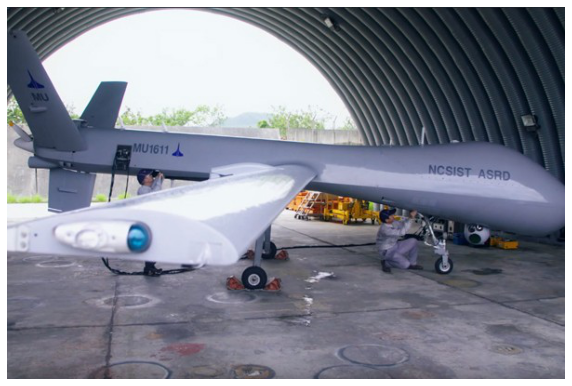

In [9]:
#@title Wybierz indeks przykładowego zdjęcia drona ze zbioru treningowego:

idx = 599 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(drone_fnames))
img_path = os.path.join(train_drone_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 584.5, 389.5, -0.5)

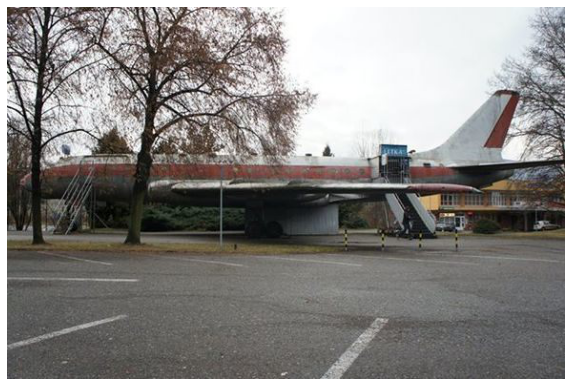

In [10]:
#@title Wybierz indeks przykładowego zdjęcia samolotu pasażerskiego ze zbioru treningowego:

idx = 800 #@param {type:'slider', min:0, max:919}
names_mapping = dict(enumerate(passenger_fnames))
img_path = os.path.join(train_passenger_dir, names_mapping[idx])

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

### <a name='a4'></a> Augmentcja danych

In [47]:
train_datagen = ImageDataGenerator(
    rotation_range=40,     # zakres kąta o który losowo zostanie wykonany obrót obrazów
    rescale=1./255.,
    width_shift_range=0.2,  # pionowe przekształcenia obrazu
    height_shift_range=0.2, # poziome przekształcenia obrazu
    shear_range=0.2,        # zares losowego przycianania obrazu
    zoom_range=0.2,         # zakres losowego przybliżania obrazu
    horizontal_flip=True,   # losowe odbicie połowy obrazu w płaszczyźnie poziomej
    fill_mode='nearest'     # strategia wypełniania nowo utworzonych pikseli, któe mogą powstać w wyniku przekształceń
)

# przeskalowujemy wszystkie obrazy o współczynnik 1/255
valid_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(directory=train_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

valid_generator = valid_datagen.flow_from_directory(directory=valid_dir,
                                                   target_size=(150, 150),
                                                   batch_size=32,
                                                   class_mode='binary')

Found 1838 images belonging to 2 classes.
Found 524 images belonging to 2 classes.


In [48]:
def display_augmented_images(directory, idx):
    """
    Funkcja zwraca wykres przykładowych obrazów uzyskanych za pomocą techniki
    augmentacji danych.
    """
    fnames = [os.path.join(directory, fname) for fname in os.listdir(directory)]
    img_path = fnames[idx]
    img = image.load_img(img_path, target_size=(150, 150))

    x = image.img_to_array(img)
    x = x.reshape((1, ) + x.shape)

    i = 1
    plt.figure(figsize=(16, 8))
    for batch in train_datagen.flow(x, batch_size=1):
        plt.subplot(3, 4, i)
        plt.grid(False)
        imgplot = plt.imshow(image.array_to_img(batch[0]))
        i += 1
        if i % 13 == 0:
            break

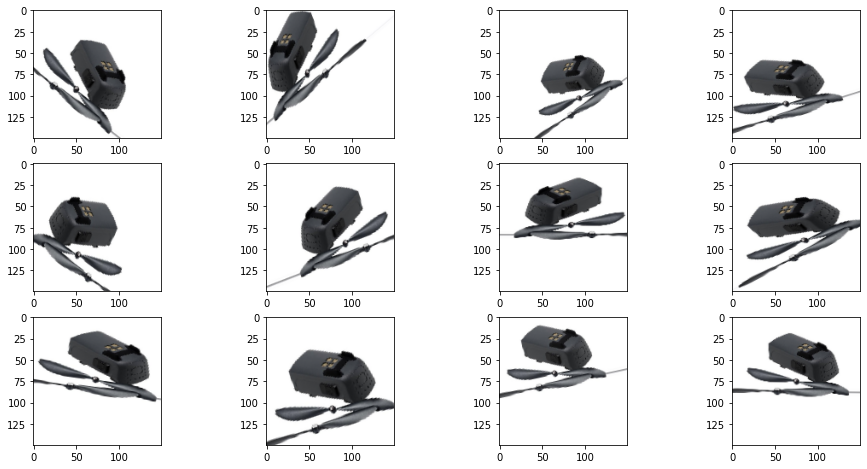

In [13]:
#@title Zbiór treningowy drone:
idx = 467 #@param {type:'slider', min:0, max:919}            
display_augmented_images(train_drone_dir, idx)

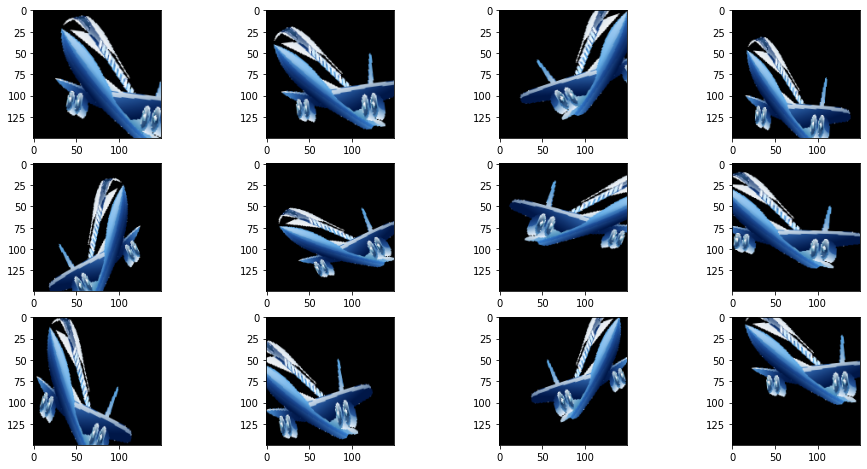

In [14]:
#@title Zbiór treningowy passenger:
idx = 111 #@param {type:'slider', min:0, max:919}
display_augmented_images(train_passenger_dir, idx)

### <a name='a5'></a> Budowa modelu

In [15]:
model = Sequential()
model.add(layers.Conv2D(filters=32, kernel_size=(3, 3), activation='relu', input_shape=(150, 150, 3)))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(3, 3), activation='relu'))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Flatten())
model.add(layers.Dense(units=512, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 15, 15, 128)       1

In [16]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics='accuracy')

In [17]:
!rm -rf logs
!mkdir logs

tensorboard = TensorBoard(log_dir='logs')

In [50]:
batch_size = 32
steps_per_epoch = train_size // batch_size
validation_steps = valid_size // batch_size

In [19]:
history = model.fit_generator(generator=train_generator,
                             steps_per_epoch=steps_per_epoch,
                             epochs=30,    # 100
                             validation_data=valid_generator,
                             validation_steps=validation_steps,
                             callbacks=[tensorboard], verbose=False)

/usr/local/lib/python3.7/dist-packages/keras/engine/training.py:1972: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



In [ ]:
%load_ext tensorboard

In [ ]:
!tensorboard dev upload --logdir logs

In [20]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.694072,0.513393,0.676910,0.652344,0
1,0.686614,0.547991,0.678006,0.578125,1
2,0.681214,0.561384,0.710236,0.519531,2
3,0.680148,0.553571,0.657860,0.621094,3
4,0.660404,0.606027,0.642478,0.625000,4


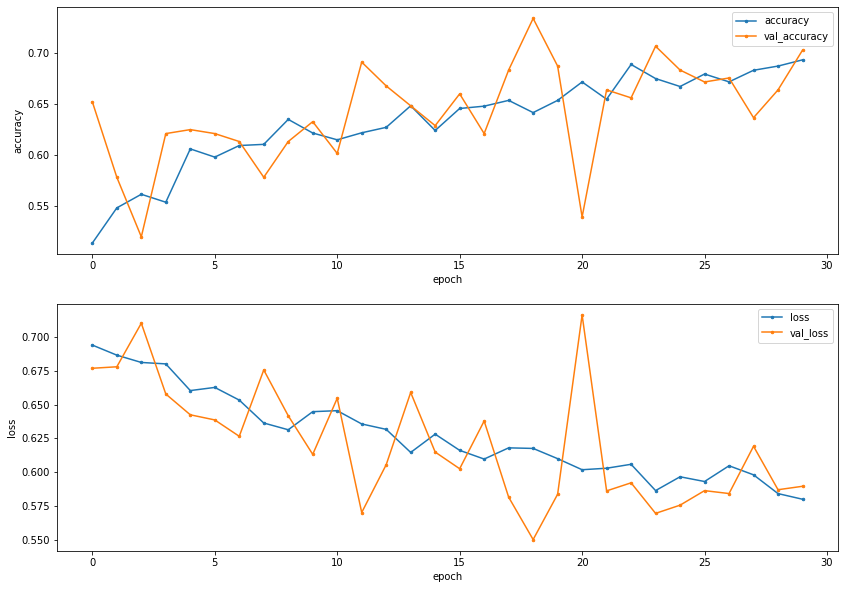

In [21]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(hist['epoch'], hist['accuracy'], marker = '.', markersize = 5, label='accuracy')
plt.plot(hist['epoch'], hist['val_accuracy'], marker = '.', markersize = 5, label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(212)
plt.plot(hist['epoch'], hist['loss'], marker = '.', markersize = 5, label='loss')
plt.plot(hist['epoch'], hist['val_loss'], marker = '.', markersize = 5, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### <a name='a6'></a> Transfer learning - model VGG16

In [6]:
from tensorflow.keras.applications import VGG16

conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [7]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 256)               2097408   
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 16,812,353
Non-trainable params: 0
_________________________________________________________________


In [24]:
conv_base.trainable = False
print(f'Liczba warstw trenowanych po zamrożeniu: {len(model.trainable_weights)}')

Liczba warstw trenowanych po zamrożeniu: 4


In [25]:
model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics='accuracy')

In [26]:
history = model.fit(x=train_generator,
                   steps_per_epoch=steps_per_epoch,
                   epochs=30,    # 100
                   validation_data=valid_generator,
                   validation_steps=validation_steps,
                   callbacks=[tensorboard], verbose=False)

In [27]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.680076,0.633929,0.534622,0.722656,0
1,0.556779,0.690205,0.512608,0.722656,1
2,0.523030,0.723214,0.472732,0.757812,2
3,0.506221,0.746652,0.470343,0.761719,3
4,0.477665,0.762277,0.455996,0.773438,4


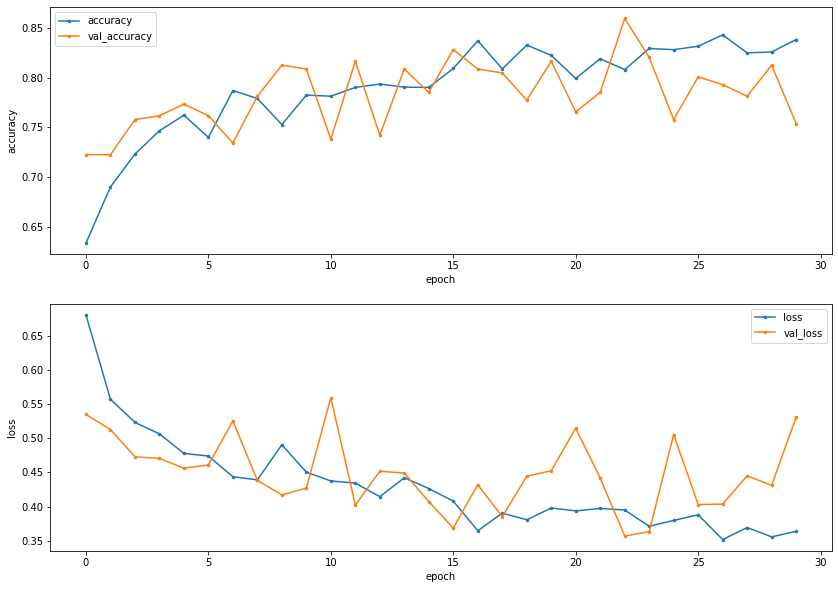

In [28]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(hist['epoch'], hist['accuracy'], marker = '.', markersize = 5, label='accuracy')
plt.plot(hist['epoch'], hist['val_accuracy'], marker = '.', markersize = 5, label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(212)
plt.plot(hist['epoch'], hist['loss'], marker = '.', markersize = 5, label='loss')
plt.plot(hist['epoch'], hist['val_loss'], marker = '.', markersize = 5, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### <a name='a7'></a> Transfer learning - model VGG16 - odmrożenie kilku ostatnich warstw

In [15]:
conv_base = VGG16(include_top=False, weights='imagenet', input_shape=(150, 150, 3))
conv_base.trainable = False

for layer in conv_base.layers:
    print(f'layer_name: {layer.name}, trainambe: {layer.trainable}')

layer_name: input_8, trainambe: False
layer_name: block1_conv1, trainambe: False
layer_name: block1_conv2, trainambe: False
layer_name: block1_pool, trainambe: False
layer_name: block2_conv1, trainambe: False
layer_name: block2_conv2, trainambe: False
layer_name: block2_pool, trainambe: False
layer_name: block3_conv1, trainambe: False
layer_name: block3_conv2, trainambe: False
layer_name: block3_conv3, trainambe: False
layer_name: block3_pool, trainambe: False
layer_name: block4_conv1, trainambe: False
layer_name: block4_conv2, trainambe: False
layer_name: block4_conv3, trainambe: False
layer_name: block4_pool, trainambe: False
layer_name: block5_conv1, trainambe: False
layer_name: block5_conv2, trainambe: False
layer_name: block5_conv3, trainambe: False
layer_name: block5_pool, trainambe: False


In [30]:
set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'block5_conv1':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [31]:
for layer in conv_base.layers:
    print(f'layer_name: {layer.name}, trainambe: {layer.trainable}')

layer_name: input_8, trainambe: False
layer_name: block1_conv1, trainambe: False
layer_name: block1_conv2, trainambe: False
layer_name: block1_pool, trainambe: False
layer_name: block2_conv1, trainambe: False
layer_name: block2_conv2, trainambe: False
layer_name: block2_pool, trainambe: False
layer_name: block3_conv1, trainambe: False
layer_name: block3_conv2, trainambe: False
layer_name: block3_conv3, trainambe: False
layer_name: block3_pool, trainambe: False
layer_name: block4_conv1, trainambe: False
layer_name: block4_conv2, trainambe: False
layer_name: block4_conv3, trainambe: False
layer_name: block4_pool, trainambe: False
layer_name: block5_conv1, trainambe: True
layer_name: block5_conv2, trainambe: True
layer_name: block5_conv3, trainambe: True
layer_name: block5_pool, trainambe: True


In [33]:
model = Sequential()
model.add(conv_base)
model.add(layers.Flatten())
model.add(layers.Dense(units=256, activation='relu'))
model.add(layers.Dense(units=1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(learning_rate=1e-4),
              loss='binary_crossentropy',
              metrics='accuracy')
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_2 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 256)               2097408   
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 16,812,353
Trainable params: 2,097,665
Non-trainable params: 14,714,688
_________________________________________________________________


In [52]:
history = model.fit(x=train_generator,
                   steps_per_epoch=steps_per_epoch,
                   epochs=30,    # 100
                   validation_data=valid_generator,
                   validation_steps=validation_steps,
                   verbose=False)

In [53]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.head()

,loss,accuracy,val_loss,val_accuracy,epoch
0,0.627200,0.670843,0.516515,0.757812,0
1,0.537361,0.720982,0.604362,0.664062,1
2,0.546821,0.731027,0.514163,0.710938,2
3,0.498008,0.754464,0.475065,0.742188,3
4,0.457992,0.766741,0.439857,0.796875,4


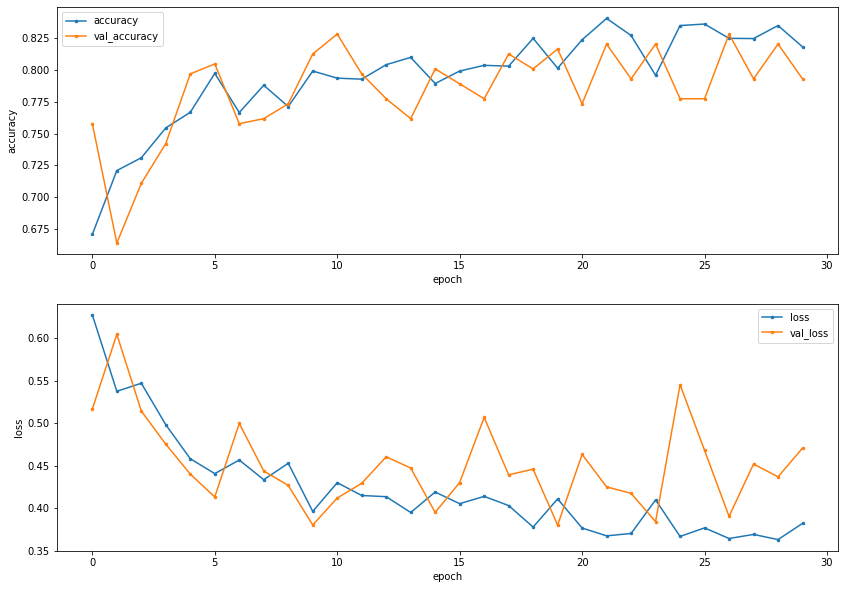

In [54]:
plt.figure(figsize=(14, 10))
plt.subplot(211)
plt.plot(hist['epoch'], hist['accuracy'], marker = '.', markersize = 5, label='accuracy')
plt.plot(hist['epoch'], hist['val_accuracy'], marker = '.', markersize = 5, label='val_accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend()
plt.subplot(212)
plt.plot(hist['epoch'], hist['loss'], marker = '.', markersize = 5, label='loss')
plt.plot(hist['epoch'], hist['val_loss'], marker = '.', markersize = 5, label='val_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()
plt.show()

### <a name='a8'></a> Ocena modelu na zbiorze testowym

In [56]:
test_datagen = ImageDataGenerator(rescale=1/255)
test_generator = test_datagen.flow_from_directory(test_dir,
                                                  target_size=(150,150),
                                                  batch_size=1,
                                                  class_mode='binary',
                                                  shuffle=False)

y_prob = model.predict(test_generator, test_generator.samples)
y_prob = y_prob.ravel()
y_prob

Found 262 images belonging to 2 classes.


array([0.005076, 0.023707, 0.026155, 0.029848, 0.00444 , 0.448171,
       0.002591, 0.0354  , 0.004301, 0.031039, 0.529715, 0.08286 ,
       0.961474, 0.039468, 0.329342, 0.125047, 0.251237, 0.167718,
       0.000058, 0.099982, 0.04747 , 0.131367, 0.025066, 0.021333,
       0.650127, 0.839024, 0.251973, 0.33056 , 0.030598, 0.684919,
       0.003061, 0.691683, 0.407889, 0.003959, 0.002589, 0.254603,
       0.83555 , 0.319151, 0.013089, 0.013226, 0.034024, 0.002007,
       0.904309, 0.040672, 0.001621, 0.668067, 0.693142, 0.442091,
       0.67144 , 0.015208, 0.162007, 0.656333, 0.005242, 0.921354,
       0.400919, 0.708576, 0.004171, 0.951971, 0.425795, 0.000938,
       0.992402, 0.009982, 0.351314, 0.611456, 0.012583, 0.013718,
       0.627051, 0.719989, 0.186448, 0.606644, 0.248916, 0.208274,
       0.021354, 0.118462, 0.587669, 0.362116, 0.841098, 0.401867,
       0.454311, 0.841787, 0.397729, 0.697335, 0.955664, 0.622272,
       0.381057, 0.014949, 0.000644, 0.083466, 0.580523, 0.083

In [58]:
predictions  = pd.DataFrame({'y_prob': y_prob})
predictions['class'] = predictions['y_prob'].apply(lambda x: 1 if x > 0.5 else 0)
predictions.head(20)

,y_prob,class
0,0.005076,0
1,0.023707,0
2,0.026155,0
3,0.029848,0
4,0.004440,0
5,0.448171,0
6,0.002591,0
7,0.035400,0
8,0.004301,0
9,0.031039,0


In [59]:
y_true = test_generator.classes
y_true

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
      dtype=int32)

In [60]:
y_pred = predictions['class'].values
y_pred

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0,
       0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0,
       1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0,
       1, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0,
       1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0])

In [61]:
test_generator.class_indices

{'drone': 0, 'passenger': 1}

In [62]:
cm = confusion_matrix(y_true, y_pred)
cm

array([[ 90,  41],
       [ 13, 118]])

In [63]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.87      0.69      0.77       131
           1       0.74      0.90      0.81       131

    accuracy                           0.79       262
   macro avg       0.81      0.79      0.79       262
weighted avg       0.81      0.79      0.79       262



### <a name='a9'></a> Wyświetlenie błędów predykcji

In [64]:
errors = pd.DataFrame({'y_true': y_true, 'y_pred': y_pred}, index=test_generator.filenames)
errors.head()

,y_true,y_pred
drone/00000007.jpg,0,0
drone/00000019.jpg,0,0
drone/00000026.png,0,0
drone/00000046.jpg,0,0
drone/00000048.jpg,0,0


In [66]:
errors['incorrect'] = (errors['y_true'] != errors['y_pred'] )*1
errors.head()

,y_true,y_pred,incorrect
drone/00000007.jpg,0,0,0
drone/00000019.jpg,0,0,0
drone/00000026.png,0,0,0
drone/00000046.jpg,0,0,0
drone/00000048.jpg,0,0,0


In [67]:
errors[errors['incorrect'] == 1].index

Index(['drone/00000085.jpg', 'drone/00000108.jpg', 'drone/00000258.jpg',
       'drone/00000266.jpg', 'drone/00000317.jpg', 'drone/00000327.jpg',
       'drone/00000379.png', 'drone/00000477.jpg', 'drone/00000516.jpg',
       'drone/00000539.jpg', 'drone/00000547.jpg', 'drone/00000561.jpg',
       'drone/00000591.jpg', 'drone/00000650.jpg', 'drone/00000660.jpg',
       'drone/00000678.jpg', 'drone/00000709.jpg', 'drone/00000746.jpg',
       'drone/00000752.jpg', 'drone/00000787.png', 'drone/00000829.JPG',
       'drone/00000849.jpg', 'drone/00000887.jpg', 'drone/00000909.jpg',
       'drone/00000910.jpg', 'drone/00000929.jpg', 'drone/00000965.jpg',
       'drone/00000980.jpeg', 'drone/00000986.jpg', 'drone/00001028.jpg',
       'drone/00001116.png', 'drone/00001126.jpg', 'drone/00001136.jpg',
       'drone/00001148.jpg', 'drone/00001277.jpg', 'drone/00001309.jpeg',
       'drone/00001320.jpg', 'drone/00001341.jpg', 'drone/00001342.jpg',
       'drone/00001383.jpg', 'drone/00001414.jpg'

(-0.5, 2787.5, 2786.5, -0.5)

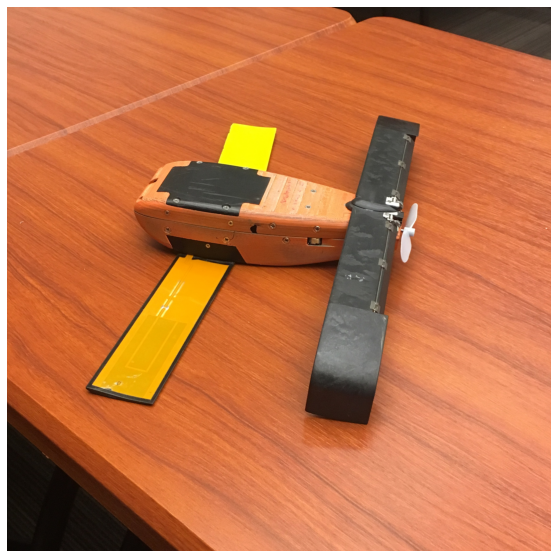

In [72]:
img_path = os.path.join(test_drone_dir, '00001414.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)

(-0.5, 579.5, 325.5, -0.5)

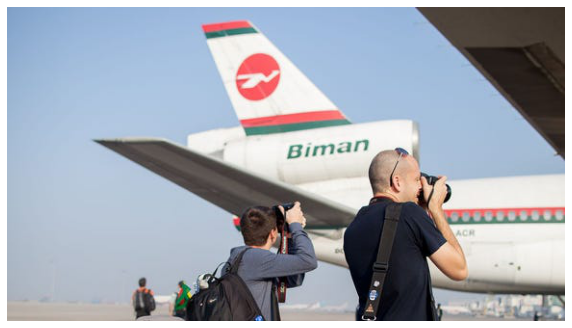

In [78]:
img_path = os.path.join(test_passenger_dir, '00001164.jpg')

img = image.load_img(img_path)

plt.figure(figsize=(10, 10))
plt.imshow(img)
plt.grid(False)
plt.axis(False)